# Assignment 4 - BONUS

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

from collections import Counter

# use imblearn to re-balance data
from imblearn.under_sampling import RandomUnderSampler

tf.get_logger().setLevel('INFO')

2024-06-09 16:44:34.141349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 16:44:34.141834: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 16:44:34.146705: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 16:44:34.211809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 16:44:34.985269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

---
### Step 1: Data ingestion

In [2]:
# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

---
### Step 2: Exploratory Data Analysis (EDA)

In [3]:
print('X_train type:', type(X_train), '; shape:', X_train.shape)
print('Y_train type:', type(Y_train), '; shape:', Y_train.shape)
print('X_test type:', type(X_test), '; shape:', X_test.shape)
print('Y_test type:', type(Y_test), '; shape:', Y_test.shape)

# Create list of the label names, per https://keras.io/api/datasets/fashion_mnist/
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train type: <class 'numpy.ndarray'> ; shape: (60000, 28, 28)
Y_train type: <class 'numpy.ndarray'> ; shape: (60000,)
X_test type: <class 'numpy.ndarray'> ; shape: (10000, 28, 28)
Y_test type: <class 'numpy.ndarray'> ; shape: (10000,)


---
### Step 3: Data preprocessing

This step is essential for preparing this image data in a format that is suitable for ML algorithms. 

In [4]:
# Normalize data; use min and max from train set
X_train_max = X_train.max()
X_train_min = X_train.min()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

# flatten the 28x28 arrays to 1-d of 784
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

print('X_train shape = ', X_train.shape)
print('X_test shape = ', X_test.shape)


X_train shape =  (60000, 784)
X_test shape =  (10000, 784)


In [5]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

Y_train = np.where(Y_train == 7, 1, 0)
Y_test = np.where(Y_test == 7, 1, 0)


### Undersample Training Set

In [6]:
print('Original class counts for train:', Counter(Y_train))

# Undersample X_train and Y_train to balance for the 90/10 split
# of non-sneakers to snakers
rus = RandomUnderSampler(random_state=42)
X_train_resample, Y_train_resample = rus.fit_resample(X_train, Y_train)

print('New class counts for train:', Counter(Y_train_resample))

Original class counts for train: Counter({0: 54000, 1: 6000})
New class counts for train: Counter({0: 6000, 1: 6000})


In [7]:
# Split training into train and validation
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train_resample, Y_train_resample, test_size=0.2, random_state=1234) 

print('Shape of X_train_mini =', X_train_mini.shape)
print('Shape of X_val =', X_val.shape)
print('Shape of Y_train_mini =', Y_train_mini.shape)
print('Shape of Y_val =', Y_val.shape)


Shape of X_train_mini = (9600, 784)
Shape of X_val = (2400, 784)
Shape of Y_train_mini = (9600,)
Shape of Y_val = (2400,)


In [8]:
# shuffle data
np.random.seed(0)
shuffled_indices = np.random.permutation(range(len(Y_train_mini)))

X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]

---
### Step 4: Exploratory Data Analysis (EDA) - cont'd

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

Mean pixel value across all sneaker images =  0.168
Mean pixel value across all non-sneaker images =  0.298


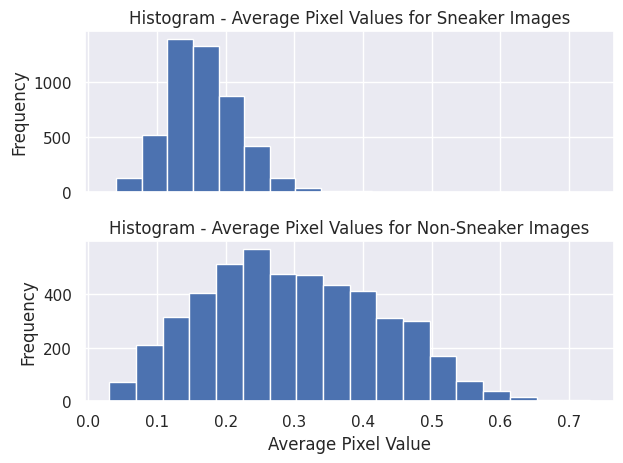

In [9]:
# get indexes for the sneaker images
sneaker_idx = np.where(Y_train_mini == 1)[0]

# get average pixel value for each sneaker sample
sneaker_pixel_averages = [s.mean() for s in X_train_mini[sneaker_idx]]
print(f'Mean pixel value across all sneaker images = {X_train_mini[sneaker_idx].mean(): 0.3f}')

# create plots of the histogram for averages; share X-axis to better
# visualize differences
fig, ax = plt.subplots(2, sharex=True)

# plot histogram of averages
ax[0].hist(sneaker_pixel_averages)
ax[0].set_title('Histogram - Average Pixel Values for Sneaker Images')
ax[0].set_ylabel('Frequency')

# get indexes for the non-sneaker images
non_sneaker_idx = np.where(Y_train_mini == 0)[0]

# get average pixel value for each non-sneaker sample
non_sneaker_pixel_averages = [s.mean() for s in X_train_mini[non_sneaker_idx]]
print(f'Mean pixel value across all non-sneaker images = {X_train_mini[non_sneaker_idx].mean(): 0.3f}')

# plot histogram of averages
ax[1].hist(non_sneaker_pixel_averages, bins=18)
ax[1].set_title('Histogram - Average Pixel Values for Non-Sneaker Images')
ax[1].set_xlabel('Average Pixel Value')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


---
### Step 4: Modeling

In [10]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch SGD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(), 
      optimizer=optimizer,
      metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    
  return model

---
### Step 5: Hyperparameter tuning

/home/jcisneros/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final loss amount for training: 0.0752
Final loss amount for validation: 0.0873
Percent difference in traning and validation losses: 16.14%


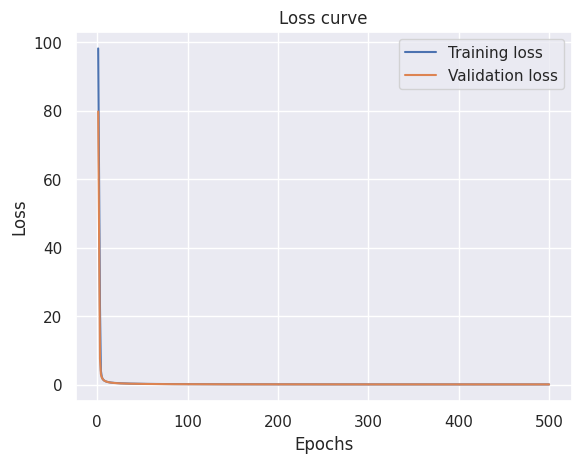

In [11]:
tf.random.set_seed(0)
# Build and compile model
learning_rate = 0.005
epochs = 500
batch_size = 32

model_tf = build_model(num_features=X_train_mini.shape[1], learning_rate=learning_rate)

# Fit the model
model_fit = model_tf.fit(
    x=X_train_mini,
    y=Y_train_mini,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=0
)

# Print model configuration
train_final_loss = model_fit.history['loss'][epochs-1]
val_final_loss = model_fit.history['val_loss'][epochs-1]
print(f'Final loss amount for training: {train_final_loss:.4f}')
print(f'Final loss amount for validation: {val_final_loss:.4f}')
print(f'Percent difference in traning and validation losses: {(val_final_loss - train_final_loss) / train_final_loss * 100:.2f}%')

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)

plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

---
### Step 6: Evaluation and Generalization

In [12]:
# evaluate model on train and test data sets
train_mini_eval = model_tf.evaluate(
    x=X_train_mini,
    y=Y_train_mini,
    verbose=0
)

test_eval = model_tf.evaluate(
    x=X_test,
    y=Y_test,
    verbose=0
)

print(f'Accuracy for train data: {train_mini_eval[1]*100:.2f}%')
print(f'Accuracy for test data: {test_eval[1]*100:.2f}%')


Accuracy for train data: 97.42%
Accuracy for test data: 96.57%


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


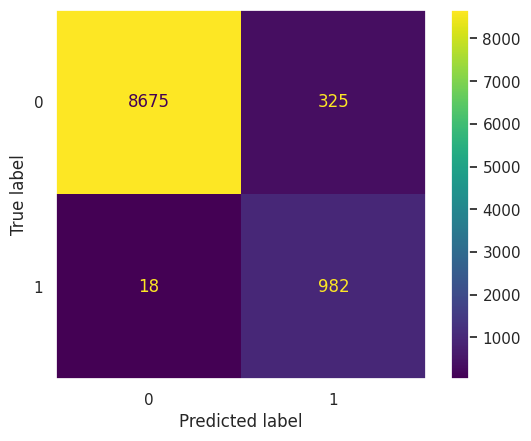

True Positives = 982
False Negatives = 18
False Positives = 325
True Negatives = 8675
Accuracy for sneakers =  98.20%
Accuracy for non-sneakers =  96.39%

The model trained on the balanced dataset has much better accuracy for the 
sneaker class at 98.2% vs 87.3% for the model trained on the full dataset. 
This was accomplished while making a relatively small trade-off in accuracy 
for non-sneakers from 98.6% using all data to 96.4% using the balanced data.
This is still better than the baseline of 90%.



In [13]:
# get the predicted values for Test
Y_test_pred = model_tf.predict(x=X_test).flatten()

# convert the probabilities to the 0, 1 class values
Y_test_pred = np.where(Y_test_pred >= 0.5, 1, 0)

# print confusion matrix
labels = ('non-sneaker', 'sneaker')
cm = confusion_matrix(Y_test, Y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

print(f'True Positives = {cm[1][1]}')
print(f'False Negatives = {cm[1][0]}')
print(f'False Positives = {cm[0][1]}')
print(f'True Negatives = {cm[0][0]}')

print(f'Accuracy for sneakers = {cm[1][1] / (cm[1][0] + cm[1][1]) * 100: .2f}%')
print(f'Accuracy for non-sneakers = {cm[0][0] / (cm[0][0] + cm[0][1]) * 100: .2f}%')

msg = """
The model trained on the balanced dataset has much better accuracy for the 
sneaker class at 98.2% vs 87.3% for the model trained on the full dataset. 
This was accomplished while making a relatively small trade-off in accuracy 
for non-sneakers from 98.6% using all data to 96.4% using the balanced data.
This is still better than the baseline of 90%.
"""
print(msg)